In [1]:
from data_model import WineData, WHITE_WINE_PATH, RED_WINE_PATH
from network import run
from torch.utils.data import Dataset, DataLoader


# Explaining pytorch model of wine quality dataset using Shap

### Train model
Firstly let's run the training loop and save the resulting model.

*NOTE*: The model has 7 classes so accuracy is calculated here for a multiclass problem where a random
guess gives us a 1/7 (0.14) random probability of being correct. The model takes class weights and distribution into account so the loss function is trying to optimize with class distribution taken into account. 

In [2]:
model = run()

Epoch[50] Loss:[0.71]
EVALUATOR: Training Results - Epoch: 50  Avg accuracy: 0.51  Avg loss: 0.7978
Epoch[100] Loss:[0.64]
EVALUATOR: Training Results - Epoch: 100  Avg accuracy: 0.51  Avg loss: 0.7821
Epoch[150] Loss:[0.79]
EVALUATOR: Training Results - Epoch: 150  Avg accuracy: 0.52  Avg loss: 0.7678
Epoch[200] Loss:[0.91]
EVALUATOR: Training Results - Epoch: 200  Avg accuracy: 0.54  Avg loss: 0.7728
Epoch[250] Loss:[0.81]
EVALUATOR: Training Results - Epoch: 250  Avg accuracy: 0.54  Avg loss: 0.7615
Epoch[300] Loss:[0.86]
EVALUATOR: Training Results - Epoch: 300  Avg accuracy: 0.53  Avg loss: 0.7600
Epoch[350] Loss:[0.81]
EVALUATOR: Training Results - Epoch: 350  Avg accuracy: 0.55  Avg loss: 0.7664
Epoch[400] Loss:[0.64]
EVALUATOR: Training Results - Epoch: 400  Avg accuracy: 0.54  Avg loss: 0.7533
Epoch[450] Loss:[0.78]
EVALUATOR: Training Results - Epoch: 450  Avg accuracy: 0.54  Avg loss: 0.7530
Epoch[500] Loss:[0.75]
EVALUATOR: Training Results - Epoch: 500  Avg accuracy: 0.53 

## Get Wine Data
Using the dataset and dataloader specified in data_model.py we import a train and test data set
and create a dataloader for each

In [3]:
data = WineData.read_data(WHITE_WINE_PATH)

train_data, test_data = WineData.train_test_splitter(data)

wd = WineData(train_data)
wd_test = WineData(test_data)


## Create DeepExplainer
Using our model we create a new instance of the `shap.DeepExplainer()` using the train data's x values as background inputs.

Shap will provide us with an *approximation* of the model's behaviour **not** the underlying data itself. 
That is to say shap approximates the model, which we hope represents our data well. However if our model is a bad fit
shap will give us an approxmiation of a bad model. 

 *garbage in, garbage out*. 

In [4]:
import shap

In [5]:
# explainer will use the first 1000 instances in x_data
e = shap.DeepExplainer(model, wd.x_data)

In [6]:
wd.x_data.shape

torch.Size([4408, 11])

In [7]:
# shap values can take a really long time to calculate
# let's limit the shap values to the first 200 rows in `wd.x_data`
shap_values = e.shap_values(wd.x_data[:200])

In [8]:
FEATURE_NAMES =["fixed acidity","volatile acidity","citric acid","residual sugar","chlorides","free sulfur dioxide","total sulfur dioxide","density","pH","sulphates","alcohol"
]

In [9]:
# shap.initjs()

# Summarizing The Model For All Classes

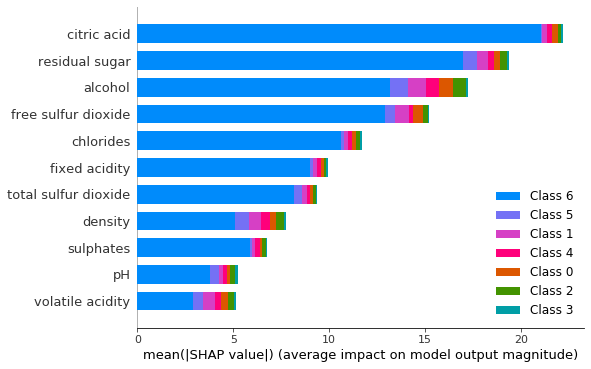

In [10]:
shap.summary_plot(shap_values, wd.x_data[:200],feature_names=FEATURE_NAMES)

# Model Summary For Class 0 (e.g. worst quality)

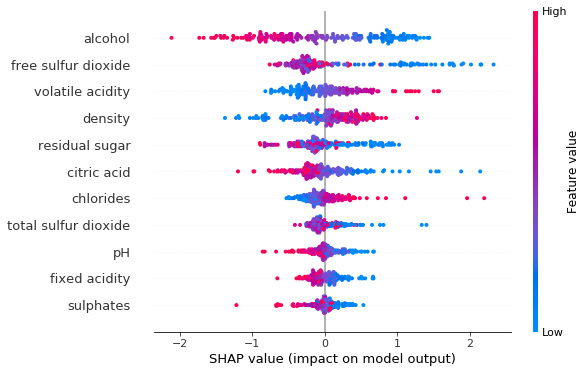

In [13]:
shap.summary_plot(shap_values[0][0:200], wd.x_data[:200], feature_names=FEATURE_NAMES)

# Model Summary For Class 1 

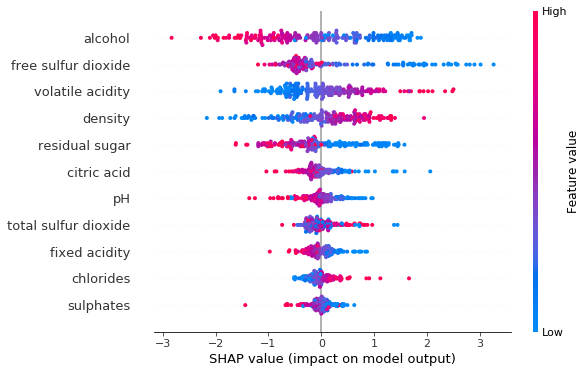

In [14]:
shap.summary_plot(shap_values[1][0:200], wd.x_data[:200], feature_names=FEATURE_NAMES)

# Model Summary For Class 2

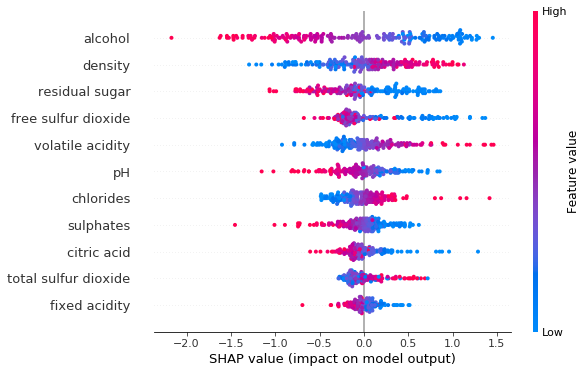

In [15]:
shap.summary_plot(shap_values[2][0:200], wd.x_data[:200], feature_names=FEATURE_NAMES)

# Model Summary For Class 3 

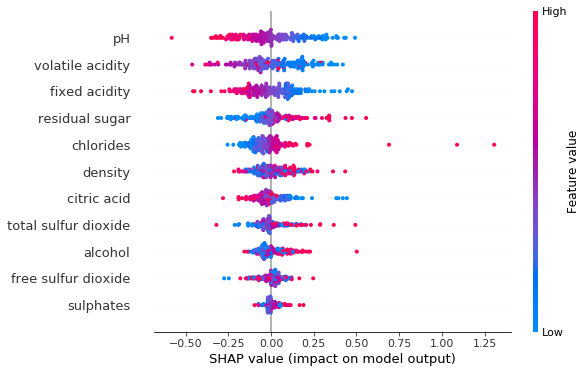

In [16]:
shap.summary_plot(shap_values[3][0:200], wd.x_data[:200], feature_names=FEATURE_NAMES)

# Model Summary For Class 4 

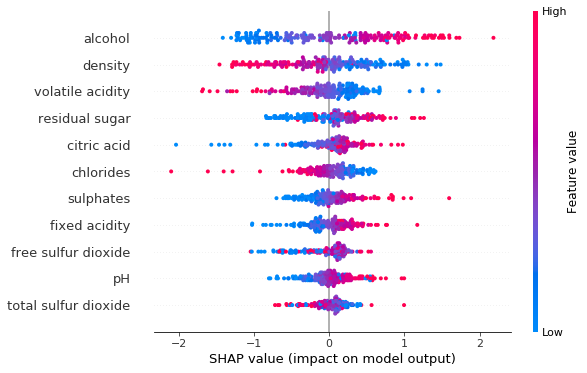

In [17]:
shap.summary_plot(shap_values[4][0:200], wd.x_data[:200], feature_names=FEATURE_NAMES)

# Model Summary For Class 5 

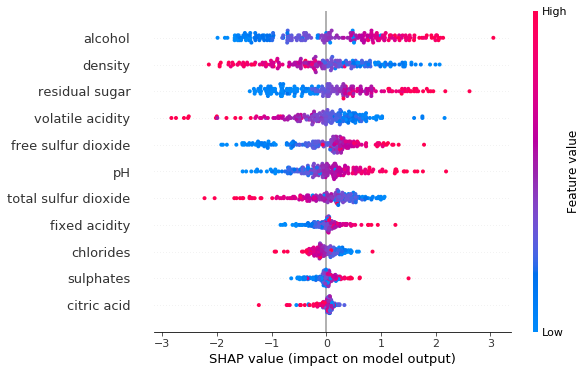

In [19]:
shap.summary_plot(shap_values[5][0:200], wd.x_data[:200], feature_names=FEATURE_NAMES)

# Model Summary For Class 6 

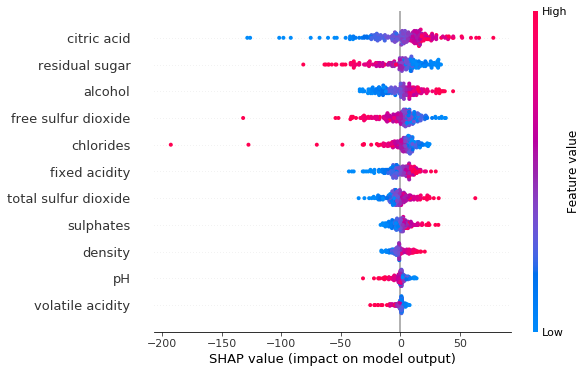

In [21]:
shap.summary_plot(shap_values[6][0:200], wd.x_data[:200], feature_names=FEATURE_NAMES)


The overall class summary for all 6 classes makes class 6 (the highest quality) look a bit suspect. Let's look closer at the class weights to see how the quality ratings are distributed, as the problem could likely be down to a lack of training data for both classes, thus model may not have learned how to represent and predict well enough for this class. 

In [22]:
quality = [i+3 for i in range(7)]

In [23]:
quality

[3, 4, 5, 6, 7, 8, 9]

In [24]:
for q, w, i in zip(quality, wd.class_weights.data,[i for i in range(7)]):
    print(f"Index {i} represents quality: {q} with class weight {w}")

Index 0 represents quality: 3 with class weight 0.004083484411239624
Index 1 represents quality: 4 with class weight 0.033348456025123596
Index 2 represents quality: 5 with class weight 0.29741379618644714
Index 3 represents quality: 6 with class weight 0.44872957468032837
Index 4 represents quality: 7 with class weight 0.17967331409454346
Index 5 represents quality: 8 with class weight 0.03561706095933914
Index 6 represents quality: 9 with class weight 0.0011343013029545546


# Summary
Clearly there are only few instances of wine's of class 6. Given that 76% of all wines are rated 6 and below. It might be better to split this problem into a binary classification task of predicting wines as bad (class 0 - 3) or good (class 4-6).